In [1]:
epochs = 5
batch_size = 128
lr = 1e-3

In [2]:
import tensorflow as tf
import numpy as np
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((-1, 784)).astype(np.float32) / 255 
x_test = x_test.reshape((-1, 784)).astype(np.float32) / 255
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


In [3]:
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [4]:
from keras import models
from keras import layers
nn = models.Sequential()
nn.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
nn.add(layers.Dense(10, activation=None))

x = nn.input
logits = nn.output
y_pred = tf.cast(tf.argmax(logits, axis=1), tf.int32, name='y_pred_cls') 

y = tf.placeholder(tf.int32, (None,)) 
entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits) 
loss = tf.reduce_mean(entropy) 
train = tf.train.RMSPropOptimizer(lr).minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Using TensorFlow backend.


In [5]:
def shuffle_batch(x, y, batch_size):
    rnd_idx = np.random.permutation(len(x))
    n_batches = len(x) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        yield x[batch_idx], y[batch_idx]

In [6]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, 'save/nn.ckpt')
    
    loss_trace = []
    accuracy_trace = []

    for i in range(epochs):
        print()
        print('epoch {}/{}'.format(i, epochs), end=' ')
        for x_batch, y_batch in shuffle_batch(x_train, y_train, batch_size):
            feed_dict = {x: x_batch, y: y_batch}
            loss_run, accuracy_run, _ = sess.run([loss, accuracy, train], feed_dict=feed_dict)
            loss_trace.append(loss_run)
            accuracy_trace.append(accuracy_run)

    feed_dict = {x: x_test, y: y_test}
    accuracy_run, y_test_pred = sess.run([accuracy, y_pred], feed_dict=feed_dict)
    
    saver.save(sess, 'save/nn.ckpt')

INFO:tensorflow:Restoring parameters from save/nn.ckpt

epoch 0/5 
epoch 1/5 
epoch 2/5 
epoch 3/5 
epoch 4/5 

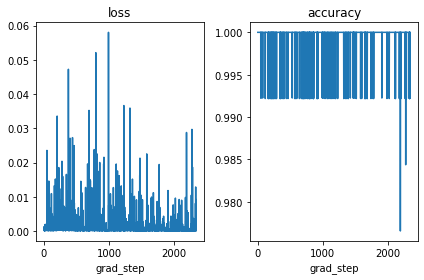

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(loss_trace)
ax2.plot(accuracy_trace)
ax1.set_title('loss')
ax2.set_title('accuracy')
ax1.set_xlabel('grad_step')
ax2.set_xlabel('grad_step')
plt.tight_layout()
plt.show()

In [8]:
print('Test Accuracy :', accuracy_run)

Test Accuracy : 0.9816


In [9]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
print(cm)

[[ 970    0    1    0    1    0    4    1    3    0]
 [   0 1127    3    1    0    1    2    1    0    0]
 [   0    2 1016    2    3    0    2    3    3    1]
 [   0    0    5  990    1    3    0    4    1    6]
 [   1    0    2    1  967    0    3    1    0    7]
 [   2    0    0    9    2  870    6    0    2    1]
 [   4    3    1    1    3    4  942    0    0    0]
 [   1    3    9    1    1    0    0 1004    2    7]
 [   2    1    4    6    5    0    3    3  944    6]
 [   1    2    0    3   10    2    0    4    1  986]]


In [10]:
dir(nn)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_inbound_node',
 '_add_unique_metric_name',
 '_base_init',
 '_build_input_shape',
 '_built',
 '_cache_output_metric_attributes',
 '_check_trainable_weights_consistency',
 '_compute_previous_mask',
 '_expects_training_arg',
 '_feed_input_names',
 '_feed_input_shapes',
 '_feed_inputs',
 '_get_callback_model',
 '_get_existing_metric',
 '_get_node_attribute_at_index',
 '_get_training_eval_metrics',
 '_handle_metrics',
 '_handle_per_output_metrics',
 '_inbound_nodes',
 '_init_graph_network',
 '_init_subclassed_network',
 '_initial_weights',
 '_input_coordinates',
 '_input_lay

In [11]:
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [12]:
nn.input

<tf.Tensor 'dense_1_input:0' shape=(?, 784) dtype=float32>

In [13]:
nn.output

<tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>

In [14]:
nn.layers

In [15]:
for layer in nn.layers:
    print(layer.name, layer.trainable)
    layer.trainable = False
    print(layer.name, layer.trainable)

dense_1 True
dense_1 False
dense_2 True
dense_2 False


In [16]:
nn.get_layer('dense_1')

In [17]:
nn.get_layer('dense_1').input

<tf.Tensor 'dense_1_input:0' shape=(?, 784) dtype=float32>

In [18]:
nn.get_layer('dense_1').output

<tf.Tensor 'dense_1/Relu:0' shape=(?, 512) dtype=float32>

In [19]:
nn.get_layer('dense_1').kernel

<tf.Variable 'dense_1/kernel:0' shape=(784, 512) dtype=float32>

In [20]:
nn.get_layer('dense_1').bias

<tf.Variable 'dense_1/bias:0' shape=(512,) dtype=float32>

In [21]:
dir(nn.get_layer('dense_1'))

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_inbound_node',
 '_built',
 '_get_existing_metric',
 '_get_node_attribute_at_index',
 '_inbound_nodes',
 '_initial_weights',
 '_losses',
 '_metrics',
 '_node_key',
 '_non_trainable_weights',
 '_outbound_nodes',
 '_per_input_losses',
 '_per_input_updates',
 '_trainable_weights',
 '_updates',
 'activation',
 'activity_regularizer',
 'add_loss',
 'add_metric',
 'add_update',
 'add_weight',
 'assert_input_compatibility',
 'batch_input_shape',
 'bias',
 'bias_constraint',
 'bias_initializer',
 'bias_regularizer',
 'build',
 'built',
 'call',
 'compute_mask',
 'compute_output_shape',
 'count_params',
 'dtype',